In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import seaborn as sns

%matplotlib inline

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    col_names= ['CA','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, sep=",", header=0, names = col_names, parse_dates=[['DATE', 'TIME']]))
    return pd.concat(dfs)
        
week_nums = [190504, 190511, 190518, 190525]
df = get_data(week_nums)

In [3]:
df['day_of_week'] = df['DATE_TIME'].dt.dayofweek

In [4]:
#df['HOUR'] = df['DATE_TIME'].map(int(time.split(':')[0]))
df['MONTH'] = df['DATE_TIME'].dt.month
# df['YEAR'] = df['DATE_TIME'].map(date_to_year)

In [5]:
df = df[df.DESC == 'REGULAR']

In [6]:
df.columns

Index(['DATE_TIME', 'CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DESC', 'ENTRIES', 'EXITS', 'day_of_week', 'MONTH'],
      dtype='object')

In [7]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH
0,2019-04-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035249,2384833,5,4
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,4
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,4
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,4
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,4


In [8]:
df["ENTRIES_DAY_BEFORE"] = (df.groupby(["CA", "UNIT", "SCP", "STATION"])["ENTRIES"].transform(lambda grp: grp.shift(1)))

In [9]:
df["EXITS_DAY_BEFORE"] = (df.groupby(["CA", "UNIT", "SCP", "STATION"])["EXITS"].transform(lambda grp: grp.shift(1)))

In [10]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE
0,2019-04-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035249,2384833,5,4,NaN,NaN
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,4,7035249.0,2384833.0
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,4,7035269.0,2384840.0
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,4,7035292.0,2384875.0
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,4,7035392.0,2384951.0


In [11]:
df.dropna(subset=["ENTRIES_DAY_BEFORE"], axis=0, inplace=True)

In [12]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["ENTRIES_DAY_BEFORE"] + row["EXITS"] - row["EXITS_DAY_BEFORE"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

In [13]:
df["HOURLY_SUM"] = df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [14]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE,HOURLY_SUM
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,4,7035249.0,2384833.0,27.0
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,4,7035269.0,2384840.0,58.0
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,4,7035292.0,2384875.0,176.0
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,4,7035392.0,2384951.0,328.0
5,2019-04-27 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035930,2385070,5,4,7035651.0,2385020.0,329.0


In [15]:
df["HOURLY_SUM"] = df.groupby(['SCP','MONTH']).HOURLY_SUM.transform(lambda x: np.where((x<0)|(x>35000),x.mask((x<0)|(x>35000)).mean(),x))
#df["EXITS_DAY_BEFORE"] = df.groupby(['SCP','MONTH']).EXITS_DAY_BEFORE.transform(lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))

In [16]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE,HOURLY_SUM
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,4,7035249.0,2384833.0,27.0
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,4,7035269.0,2384840.0,58.0
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,4,7035292.0,2384875.0,176.0
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,4,7035392.0,2384951.0,328.0
5,2019-04-27 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035930,2385070,5,4,7035651.0,2385020.0,329.0


In [17]:
top_15_stations_with_sum = df.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending = False).head(15)
print(top_15_stations_with_sum)

STATION
34 ST-PENN STA     8.016840e+06
GRD CNTRL-42 ST    6.853626e+06
34 ST-HERALD SQ    5.702104e+06
14 ST-UNION SQ     5.045479e+06
TIMES SQ-42 ST     4.895134e+06
23 ST              4.808342e+06
42 ST-PORT AUTH    4.561923e+06
FULTON ST          4.328372e+06
86 ST              4.125384e+06
125 ST             3.610646e+06
59 ST COLUMBUS     3.389135e+06
CANAL ST           3.331187e+06
59 ST              3.022021e+06
14 ST              2.987765e+06
47-50 STS ROCK     2.930321e+06
Name: HOURLY_SUM, dtype: float64


In [18]:
top_15_stations_with_sum.head(16)

STATION
34 ST-PENN STA     8.016840e+06
GRD CNTRL-42 ST    6.853626e+06
34 ST-HERALD SQ    5.702104e+06
14 ST-UNION SQ     5.045479e+06
TIMES SQ-42 ST     4.895134e+06
23 ST              4.808342e+06
42 ST-PORT AUTH    4.561923e+06
FULTON ST          4.328372e+06
86 ST              4.125384e+06
125 ST             3.610646e+06
59 ST COLUMBUS     3.389135e+06
CANAL ST           3.331187e+06
59 ST              3.022021e+06
14 ST              2.987765e+06
47-50 STS ROCK     2.930321e+06
Name: HOURLY_SUM, dtype: float64

In [19]:
top_15 = list(top_15_stations_with_sum.index[:])

In [20]:
top_15

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 '23 ST',
 '42 ST-PORT AUTH',
 'FULTON ST',
 '86 ST',
 '125 ST',
 '59 ST COLUMBUS',
 'CANAL ST',
 '59 ST',
 '14 ST',
 '47-50 STS ROCK']

In [21]:
df_top_15 = df[df['STATION'].isin(top_15)]

In [22]:
df_top_15['STATION'].nunique()

15

In [23]:
df_top_15.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE,HOURLY_SUM
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,4,7035249.0,2384833.0,27.0
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,4,7035269.0,2384840.0,58.0
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,4,7035292.0,2384875.0,176.0
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,4,7035392.0,2384951.0,328.0
5,2019-04-27 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035930,2385070,5,4,7035651.0,2385020.0,329.0


In [24]:
gb_station_top15 = df_top_15.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending=False).head(15)

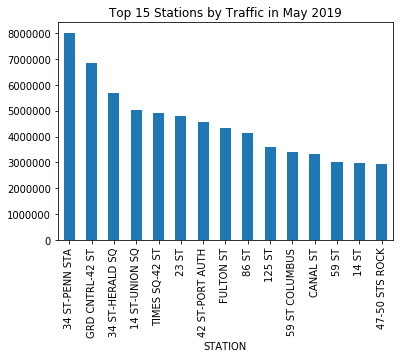

In [25]:
gb_station_top15.plot(kind='bar',title= "Top 15 Stations by Traffic in May 2019")

In [26]:
df_top_5 = df_top_15[df_top_15['STATION'].isin(['86 ST','59 ST COLUMBUS','23 ST','14 ST-UNION SQ','CANAL ST'])]

In [27]:
gb_station_top5 = df_top_5.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending=False).head(15)

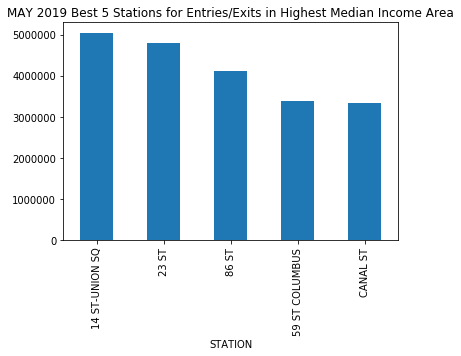

In [28]:
gb_station_top5.plot(kind='bar',title= "MAY 2019 Best 5 Stations for Entries/Exits in Highest Median Income Area")

In [29]:
df_top_5.tail(10)

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE,HOURLY_SUM
162119,2019-05-23 08:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972632609,301819543,3,5,972632892.0,301819870.0,610.0
162120,2019-05-23 12:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972631342,301819220,3,5,972632609.0,301819543.0,1590.0
162121,2019-05-23 16:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972630353,301818931,3,5,972631342.0,301819220.0,1278.0
162122,2019-05-23 20:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972628940,301818738,3,5,972630353.0,301818931.0,1606.0
162123,2019-05-24 00:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972628415,301818589,4,5,972628940.0,301818738.0,674.0
162124,2019-05-24 04:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972628392,301818561,4,5,972628415.0,301818589.0,51.0
162125,2019-05-24 08:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972628124,301818205,4,5,972628392.0,301818561.0,624.0
162126,2019-05-24 12:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972627177,301817842,4,5,972628124.0,301818205.0,1310.0
162127,2019-05-24 16:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972626304,301817547,4,5,972627177.0,301817842.0,1168.0
162128,2019-05-24 20:00:00,R250,R179,00-00-0B,86 ST,456,IRT,REGULAR,972625084,301817306,4,5,972626304.0,301817547.0,1461.0


In [30]:
gb_station_top5_by_day_of_week = df_top_5.groupby(['day_of_week'])['HOURLY_SUM'].sum().head(15)

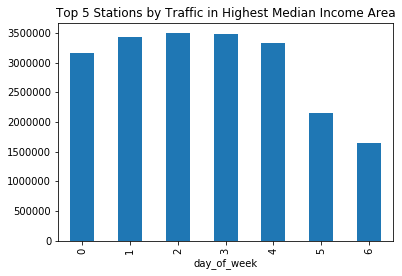

In [31]:
gb_station_top5_by_day_of_week.plot(kind='bar',title= "Top 5 Stations by Traffic in Highest Median Income Area")

In [32]:
df_top_5 = df_top_5.set_index('DATE_TIME')

In [43]:
df_top_5.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,MONTH,ENTRIES_DAY_BEFORE,EXITS_DAY_BEFORE,HOURLY_SUM
DATE_TIME,,,,,,,,,,,,,,
2019-04-27 04:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,65846,5,4,53384.0,65840.0,6.0
2019-04-27 08:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,65899,5,4,53384.0,65846.0,53.0
2019-04-27 12:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,66056,5,4,53384.0,65899.0,157.0
2019-04-27 16:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,66332,5,4,53384.0,66056.0,276.0
2019-04-27 20:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,66535,5,4,53384.0,66332.0,203.0


In [34]:
fourH_hourly_sum_top_5 = df_top_5.groupby(['STATION'])['HOURLY_SUM'].resample('4H').sum()

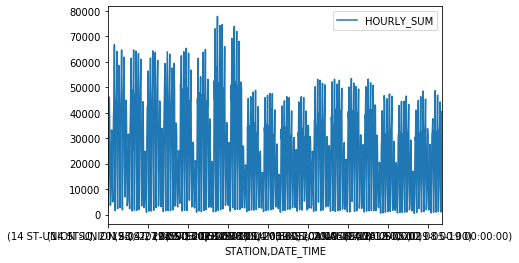

In [35]:
fourH_hourly_sum_top_5.plot(kind='line', legend=True)

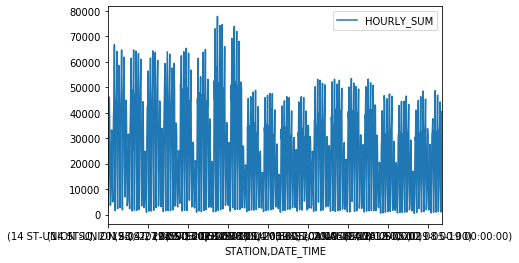

In [36]:
fourH_hourly_sum_top_5.plot(kind='line', legend=True).get_figure().savefig('output.png')

In [38]:
fourH_hourly_sum_top_5.index

MultiIndex([('14 ST-UNION SQ', '2019-04-27 00:00:00'),
            ('14 ST-UNION SQ', '2019-04-27 04:00:00'),
            ('14 ST-UNION SQ', '2019-04-27 08:00:00'),
            ('14 ST-UNION SQ', '2019-04-27 12:00:00'),
            ('14 ST-UNION SQ', '2019-04-27 16:00:00'),
            ('14 ST-UNION SQ', '2019-04-27 20:00:00'),
            ('14 ST-UNION SQ', '2019-04-28 00:00:00'),
            ('14 ST-UNION SQ', '2019-04-28 04:00:00'),
            ('14 ST-UNION SQ', '2019-04-28 08:00:00'),
            ('14 ST-UNION SQ', '2019-04-28 12:00:00'),
            ...
            (      'CANAL ST', '2019-05-23 08:00:00'),
            (      'CANAL ST', '2019-05-23 12:00:00'),
            (      'CANAL ST', '2019-05-23 16:00:00'),
            (      'CANAL ST', '2019-05-23 20:00:00'),
            (      'CANAL ST', '2019-05-24 00:00:00'),
            (      'CANAL ST', '2019-05-24 04:00:00'),
            (      'CANAL ST', '2019-05-24 08:00:00'),
            (      'CANAL ST', '2019-05-24 12:00:

In [ ]:
test = df_top_5.groupby(['STATION'])['HOURLY_SUM'].resample('4H',on='DATE_TIME').sum()

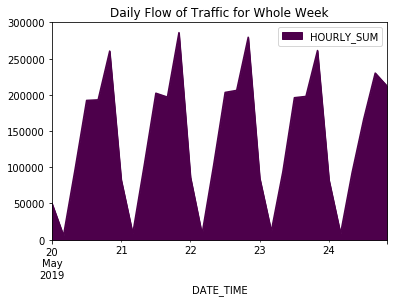

In [92]:
df_top_5['2019-05-20': '2019-05-24']['HOURLY_SUM'].resample('4H').sum().plot(legend=True,title='Daily Flow of Traffic for Whole Week',kind='area',cmap='BuPu_r').get_figure().savefig('WeekFlow.png')

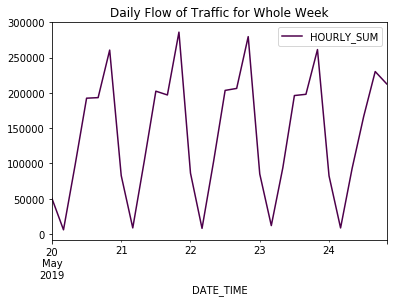

In [112]:
df_top_5['2019-05-20': '2019-05-24']['HOURLY_SUM'].resample('4H').sum().plot(legend=True,title='Daily Flow of Traffic for Whole Week',kind='line',cmap='BuPu_r').get_figure().savefig('Weekly_final.png')

In [106]:
df_top_5['2019-05-20': '2019-05-24']['HOURLY_SUM'].resample('4H').sum()

DATE_TIME
2019-05-20 00:00:00     50195.0
2019-05-20 04:00:00      5813.0
2019-05-20 08:00:00     97066.0
2019-05-20 12:00:00    192377.0
2019-05-20 16:00:00    193165.0
2019-05-20 20:00:00    260555.0
2019-05-21 00:00:00     82703.0
2019-05-21 04:00:00      8507.0
2019-05-21 08:00:00    103551.0
2019-05-21 12:00:00    202319.0
2019-05-21 16:00:00    196955.0
2019-05-21 20:00:00    285995.0
2019-05-22 00:00:00     86192.0
2019-05-22 04:00:00      7855.0
2019-05-22 08:00:00    102578.0
2019-05-22 12:00:00    203408.0
2019-05-22 16:00:00    206219.0
2019-05-22 20:00:00    279619.0
2019-05-23 00:00:00     84979.0
2019-05-23 04:00:00     11802.0
2019-05-23 08:00:00     93900.0
2019-05-23 12:00:00    196120.0
2019-05-23 16:00:00    197889.0
2019-05-23 20:00:00    261288.0
2019-05-24 00:00:00     82282.0
2019-05-24 04:00:00      8470.0
2019-05-24 08:00:00     92817.0
2019-05-24 12:00:00    166304.0
2019-05-24 16:00:00    230152.0
2019-05-24 20:00:00    212596.0
Freq: 4H, Name: HOURLY_SUM, dt

In [65]:
df_top_5['2019-05-20': '2019-05-24']['HOURLY_SUM'].resample('4H').sum()

DATE_TIME
2019-05-20 00:00:00     50195.0
2019-05-20 04:00:00      5813.0
2019-05-20 08:00:00     97066.0
2019-05-20 12:00:00    192377.0
2019-05-20 16:00:00    193165.0
2019-05-20 20:00:00    260555.0
2019-05-21 00:00:00     82703.0
2019-05-21 04:00:00      8507.0
2019-05-21 08:00:00    103551.0
2019-05-21 12:00:00    202319.0
2019-05-21 16:00:00    196955.0
2019-05-21 20:00:00    285995.0
2019-05-22 00:00:00     86192.0
2019-05-22 04:00:00      7855.0
2019-05-22 08:00:00    102578.0
2019-05-22 12:00:00    203408.0
2019-05-22 16:00:00    206219.0
2019-05-22 20:00:00    279619.0
2019-05-23 00:00:00     84979.0
2019-05-23 04:00:00     11802.0
2019-05-23 08:00:00     93900.0
2019-05-23 12:00:00    196120.0
2019-05-23 16:00:00    197889.0
2019-05-23 20:00:00    261288.0
2019-05-24 00:00:00     82282.0
2019-05-24 04:00:00      8470.0
2019-05-24 08:00:00     92817.0
2019-05-24 12:00:00    166304.0
2019-05-24 16:00:00    230152.0
2019-05-24 20:00:00    212596.0
Freq: 4H, Name: HOURLY_SUM, dt

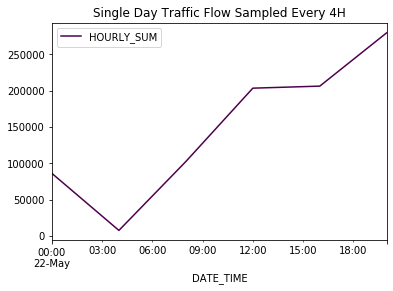

In [115]:
df_top_5['2019-05-22']['HOURLY_SUM'].resample('4H').sum().plot(legend=True,title='Single Day Traffic Flow Sampled Every 4H',kind='line',cmap='BuPu_r').get_figure().savefig('SingleDay4H_fina__test.png', bb_box = 'tight')

In [100]:
df_top_5['2019-05-22']['HOURLY_SUM'].resample('4H').mean()

DATE_TIME
2019-05-22 00:00:00     318.051661
2019-05-22 04:00:00      29.092593
2019-05-22 08:00:00     377.125000
2019-05-22 12:00:00     745.084249
2019-05-22 16:00:00     755.380952
2019-05-22 20:00:00    1024.245421
Freq: 4H, Name: HOURLY_SUM, dtype: float64

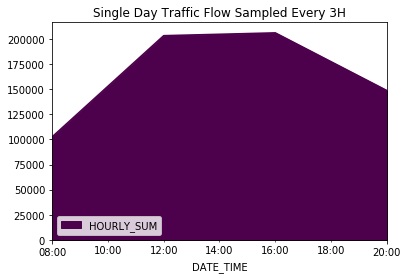

In [97]:
df_top_5['2019-05-22 8:00:00': '2019-05-22 20:00:00']['HOURLY_SUM'].resample('4H').sum().plot(legend=True,title='Single Day Traffic Flow Sampled Every 3H',kind='area',cmap='BuPu_r')